In [1]:
%run flow_tools.py

In [2]:
folders = [box_dir + 'BadIdea/Flow/20210202 - HexaPro LCB1 Time Course 24hr/',
           box_dir + 'BadIdea/Flow/20210203 - HexaPro LCB1 Time Course 48hr/',
           box_dir + 'BadIdea/Flow/20210204 - HexaPro LCB1 Time Course 72hr/']

In [3]:
df = pd.concat([load_data(folder, colnames = ["WellName", "Sender", "Receiver",
                                              'Ratio','Timepoint','Replicate','Condition'])
               for folder in folders])
df2 = clean_data(df)

In [4]:
df2.loc[df2['Receiver'] == 'LCB1-Notch', 'Receiver'] = 'SARSNotch'

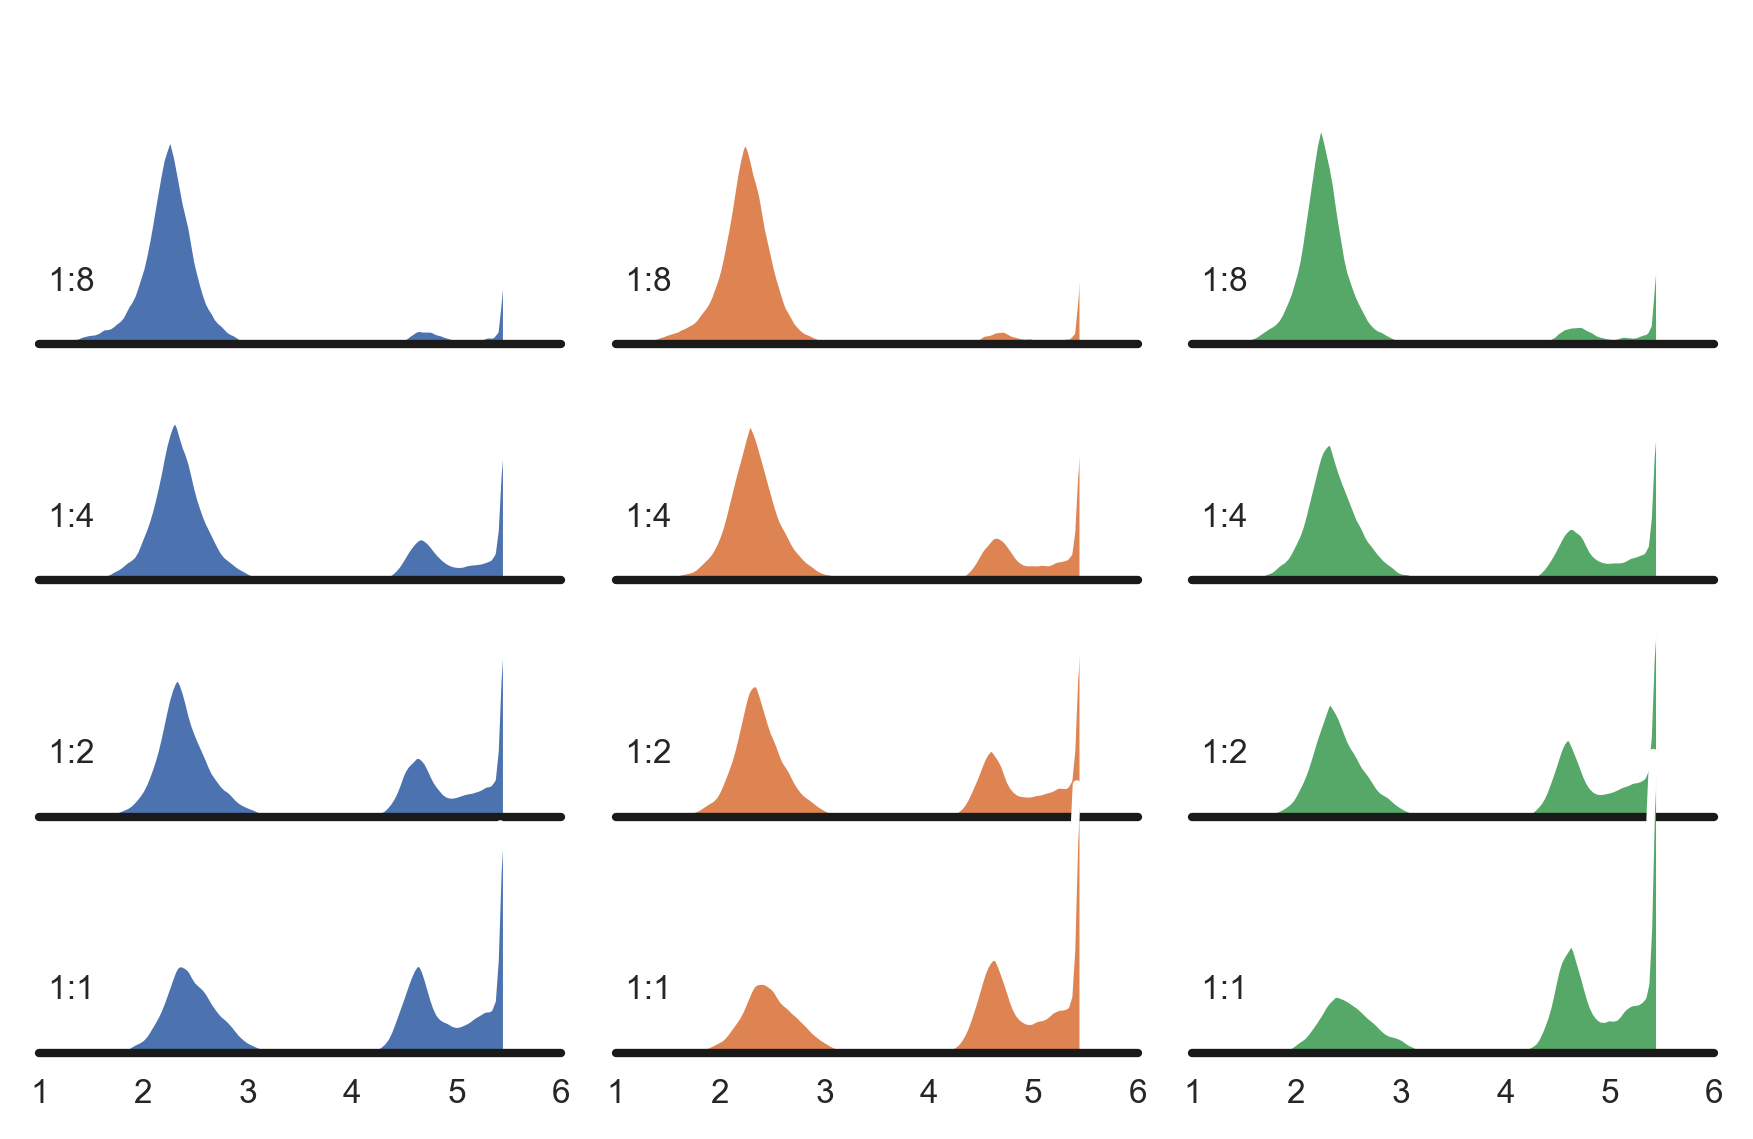

In [63]:
g = sns.FacetGrid(data=df2[(df2['Receiver'] == 'No Notch') &
                           (df2['Sender'] == 'Spike-K562')],
                  col="Replicate", row='Ratio', hue='Replicate', sharey=True, aspect=2, height=1, xlim=[1, 6])
g.map(sns.kdeplot, "logFITC-A", shade=True, alpha=1, bw_adjust=0.2, cut=0)
g.map(sns.kdeplot, "logFITC-A", color="w", lw=2, bw_adjust=.2, cut=0)
g.map(plt.axhline, y=0, lw=2, color='k', clip_on=False)

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)

for ax in g.axes.flat:
    dose = ax.get_title().split("=")[1].split('|')[0]
    ax.text(0,0.2, "{}".format(dose), ha="left", va="center", 
            bbox=dict(facecolor='white', alpha=0.5), transform=ax.transAxes)
    ax.set(facecolor=(0, 0, 0, 0))

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.fig.set_dpi(300)
g.despine(bottom=True, left=True)

In [5]:
# calculate actual ratio of receivers to sender, not just the predicted ratio.
def get_density(dist, model, k562_component):
    ids = model.predict(dist[:,np.newaxis])
    k562_ratio = np.sum(ids==k562_component)/np.sum(ids!=k562_component)
    return k562_ratio

sentinel_filter = ((df2.Receiver == 'No Notch') &
                   (df2.Sender == 'None'))
k562_filter = ((df2.Receiver == 'None') &
               (df2.Sender == 'K562'))
joint_dist = df2[sentinel_filter | k562_filter]['logFITC-A'].values[:,np.newaxis]
celltype_model = GaussianMixture(2, covariance_type='spherical',random_state=237).fit(joint_dist)
k562_component, sentinel_component = np.argsort(celltype_model.means_.flat)
df2['Computed Density'] = (df2
                           .groupby(['Timepoint','Sender', 'Receiver','Ratio', 'Replicate'])['logFITC-A']
                           .transform(lambda x: get_density(x, celltype_model, k562_component)))

/Volumes/Coatamer/Users/weinberz/miniconda3/envs/flow/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in long_scalars
  after removing the cwd from sys.path.


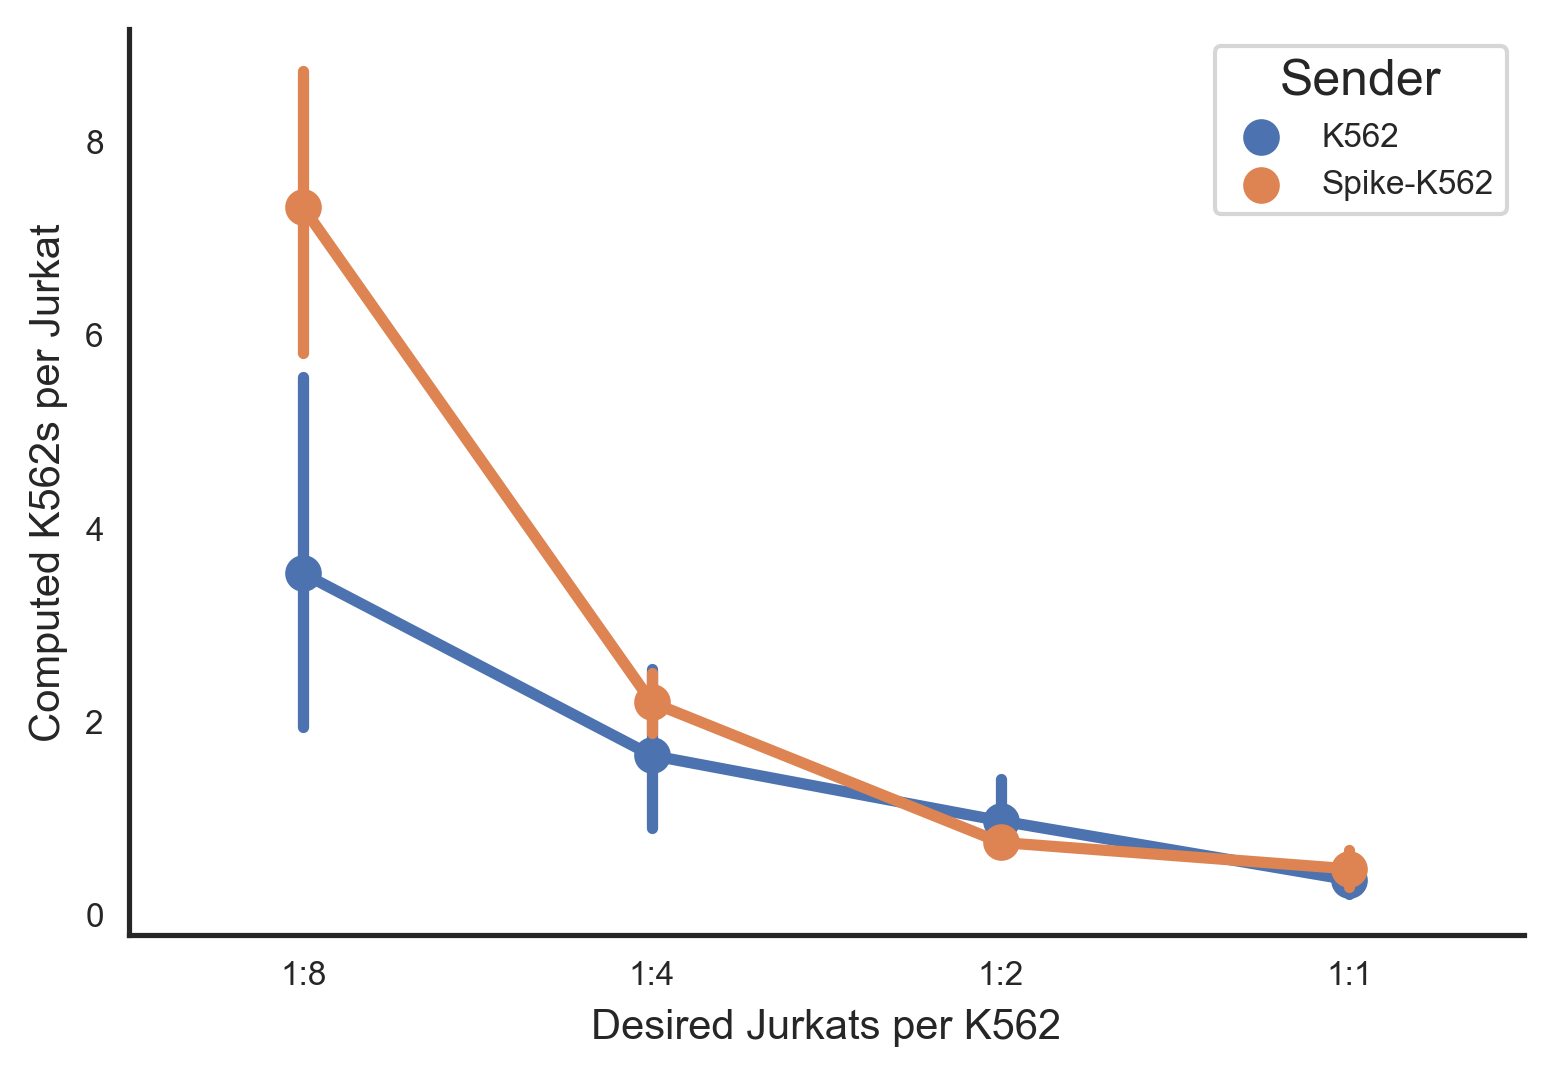

In [12]:
plt.figure(dpi=300)
output = (df2[(df2.Sender != 'None') &
              (df2.Receiver != 'None') &
              (df2.Timepoint == '72')]
          .groupby(['Sender','Receiver','Ratio','Replicate'])['Computed Density']
          .mean()
          .reset_index())
sns.pointplot(data=output,
              x='Ratio',y='Computed Density', hue='Sender', markersize=0.1,
              order=['1:8', '1:4', '1:2','1:1'])
plt.xlabel('Desired Jurkats per K562')
plt.ylabel('Computed K562s per Jurkat')
sns.despine()

In [15]:
filters = ((df2['logFITC-A'] > 4) &
           (df2.Receiver.isin(['No Notch', 'SARSNotch'])))
dist = df2[filters]['logBV 421-A'].values[:,np.newaxis]
model = GaussianMixture(2, covariance_type='spherical', random_state=237).fit(dist)
off_component = np.argmin(model.means_)
df_summary = (df2[filters]
              .groupby(['Sender','Receiver','Timepoint','Ratio', 'Replicate'])['logBV 421-A']
              .apply(lambda x: 100*(1-np.sum(model.predict(x.values[:,np.newaxis])==off_component)/len(x)))
              .reset_index())

In [6]:
receivers = ['SARSNotch', 'No Notch']
senders = ['K562', 'Spike-K562']
colors = {'No Notch' : '#8C9696', 'SARSNotch' : '#4272B8'}
linestyles = {'K562' : ':', 'Spike-K562': '-'}

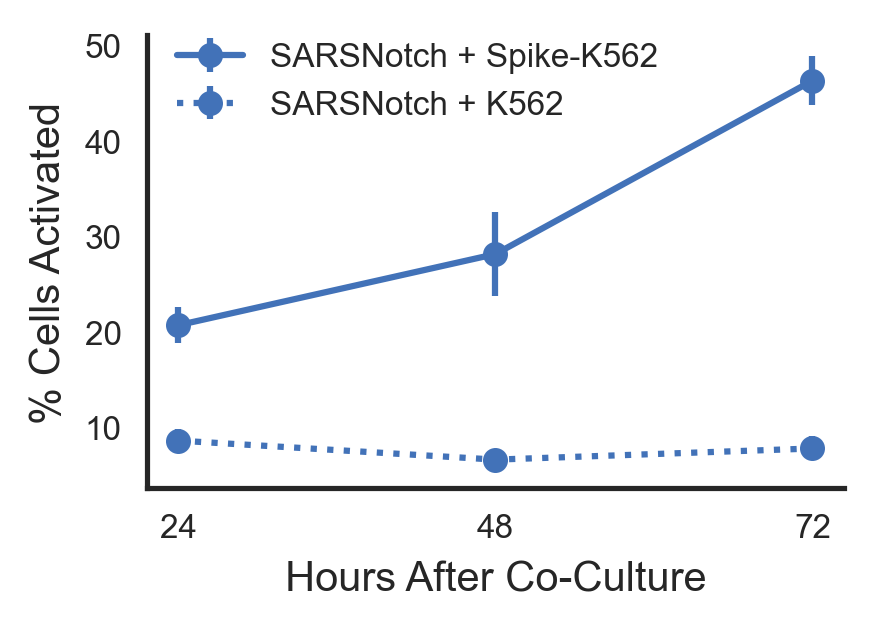

In [19]:
fig, ax = plt.subplots(1,1,figsize=(3,2), dpi=300)
for sender, receiver in product(senders, ['SARSNotch']):
    condition_summary = df_summary[(df_summary['Receiver']==receiver) & 
                                   (df_summary['Sender']==sender) &
                                   (df_summary['Ratio'] == '1:1')]
    output = (condition_summary
              .groupby('Timepoint')['logBV 421-A']
              .agg([np.mean, np.std])
              .reset_index())
    ax.errorbar(output['Timepoint'], output['mean'], yerr=output['std'], 
                fmt='-', c=colors[receiver], 
                label=f'{receiver} + {sender}',
                marker='.', markersize=10, ls=linestyles[sender])

ax.set_xlabel('Hours After Co-Culture')
ax.set_ylabel('% Cells Activated')
plt.legend()
handles, labels = ax.get_legend_handles_labels()
order = [1, 0]
plt.legend([handles[idx] for idx in order],
           [labels[idx] for idx in order],
           frameon=False, loc='upper left', bbox_to_anchor=(0,1.05))
sns.despine()
plt.savefig(outputdir + 'cell_cell_timecourse.svg')

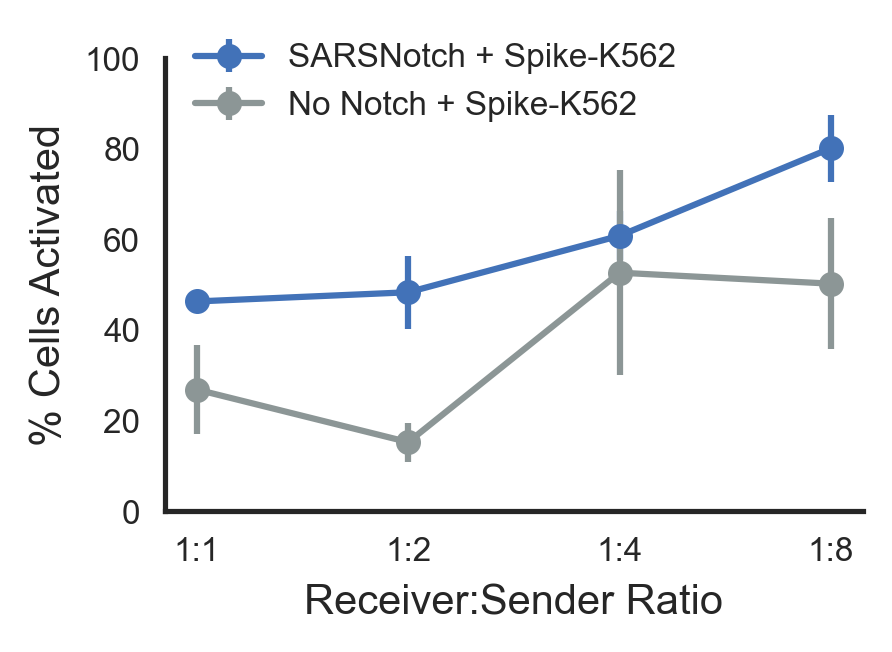

In [20]:
fig, ax = plt.subplots(1,1,figsize=(3,2), dpi=300)
for receiver in receivers:
    condition_summary = df_summary[(df_summary['Receiver']==receiver) & 
                                   (df_summary['Sender']=='Spike-K562') &
                                   (df_summary['Timepoint'] == '72')]
    output = (condition_summary
              .groupby('Ratio')['logBV 421-A']
              .agg([np.mean, np.std])
              .reset_index()
              .sort_values('Ratio', ascending=True))
    ax.errorbar(output['Ratio'], output['mean'], yerr=output['std'], 
                fmt='-', c=colors[receiver], 
                label=f'{receiver} + {sender}',
                marker='.', markersize=10, ls=linestyles[sender])

ax.set_xlabel('Receiver:Sender Ratio')
ax.set_ylabel('% Cells Activated')
plt.ylim([0,100])
plt.legend()
handles, labels = ax.get_legend_handles_labels()
order = [0,1]
plt.legend([handles[idx] for idx in order],
           [labels[idx] for idx in order],
           frameon=False, loc='upper left', bbox_to_anchor=(0,1.1))
sns.despine()
plt.savefig(outputdir + 'cell_cell_nonspecific.svg')

In [66]:
filters = ((df2['logFITC-A'] > 4) &
           (df2.Receiver.isin(['No Notch', 'SARSNotch'])) &
           (df2.Timepoint == '72'))
dist = df2[filters]['logBV 421-A'].values[:,np.newaxis]
model = GaussianMixture(2, covariance_type='spherical', random_state=237).fit(dist)
off_component = np.argmin(model.means_)
summary = (df2[filters].groupby(['Sender','Receiver','Computed Density','Replicate'])['logBV 421-A']
              .apply(lambda x: 100*(1-np.sum(model.predict(x.values[:,np.newaxis])==off_component)/len(x)))
              .reset_index())

In [53]:
sns.pointplot(data=))

/Volumes/Coatamer/Users/weinberz/miniconda3/envs/flow/lib/python3.6/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/Volumes/Coatamer/Users/weinberz/miniconda3/envs/flow/lib/python3.6/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  from ipykernel import kernelapp as app
/Volumes/Coatamer/Users/weinberz/miniconda3/envs/flow/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


Text(0.5, 1.0, '"High" Density K562')

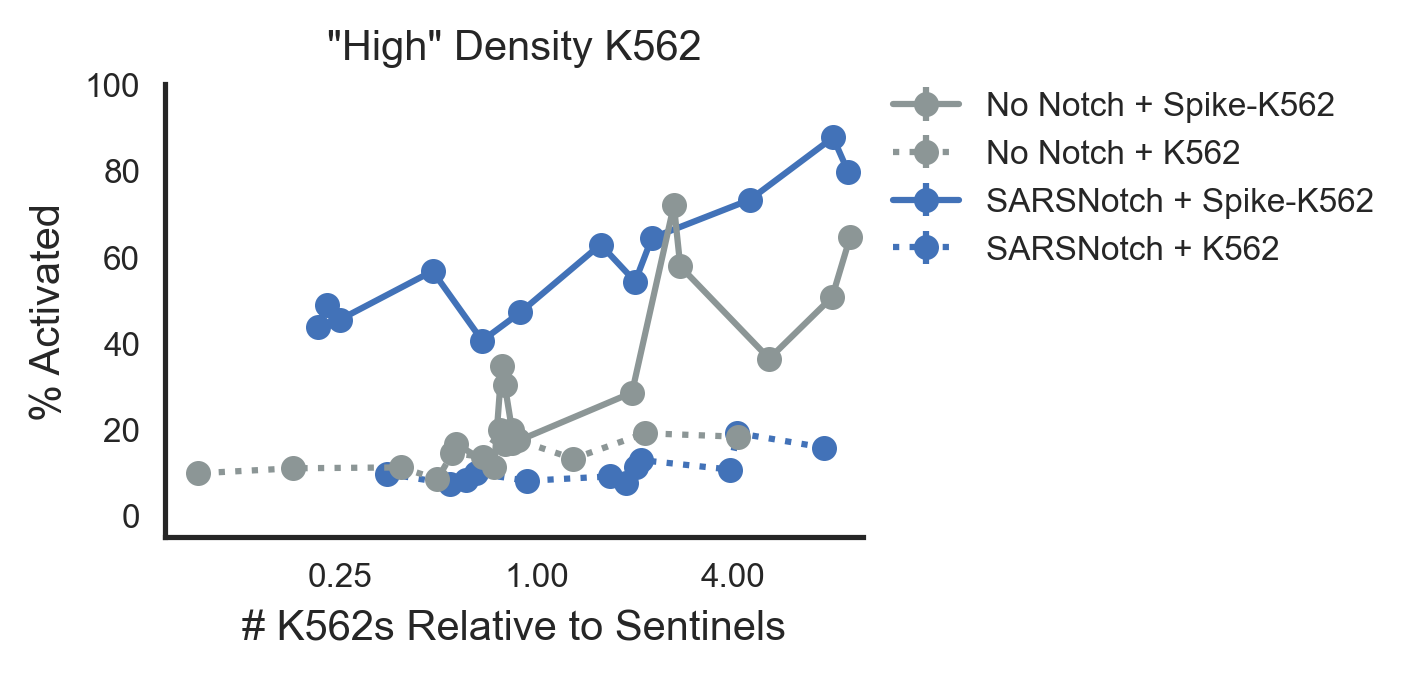

In [67]:
fig, ax = plt.subplots(1,1,figsize=(3,2), dpi=300)
for sender, receiver in product(senders, receivers):
    condition_summary = summary[(summary['Receiver']==receiver) & (summary['Sender']==sender)]
    output = (condition_summary
              .groupby('Computed Density')['logBV 421-A']
              .agg([np.mean, np.std])
              .reset_index()
              .sort_values('Computed Density', ascending=False))
    ax.errorbar(output['Computed Density'], output['mean'], yerr=output['std'], 
                fmt='-', c=colors[receiver], 
                label=f'{receiver} + {sender}',
                marker='.', markersize=10, ls=linestyles[sender])

ax.set_xlabel('# K562s Relative to Sentinels')
ax.set_xscale('log', basex=2)
ax.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
plt.legend()
handles, labels = ax.get_legend_handles_labels()
order = [3, 1, 2, 0]
plt.legend([handles[idx] for idx in order],
           [labels[idx] for idx in order],
           frameon=False, loc='upper left', bbox_to_anchor=(1,1.05))
sns.despine()
plt.xlim([0, 10])
plt.ylim([-5, 100])
plt.ylabel('% Activated')
plt.title('"High" Density K562')
#plt.savefig(outputdir + 'cell_cell_jurkats.svg')

In [25]:
df_summary['Condition'] = df_summary['Receiver'] + ':' + df_summary['Sender'] + ' ' + df_summary['Ratio']

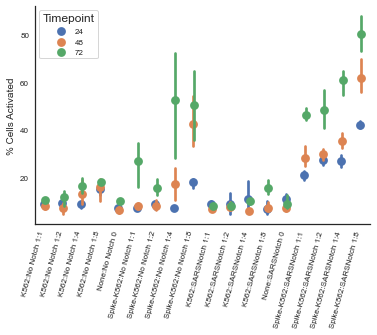

In [30]:
g = sns.pointplot(data=df_summary.sort_values(['Receiver', 'Sender', 'Ratio']), x='Condition', y='logBV 421-A', hue='Timepoint', join=False, dodge=True)
g.set_xlabel('')
g.set_ylabel('% Cells Activated')
plt.xticks(rotation=75, ha='right')
sns.despine()